# Project 1 - due 3rd Nov

## Step 1: Run pseudoexperiments for 10000 events

- the pdf is: $$p(t;\tau, \Delta m, V) \propto (1 + V\sin{\Delta m t}) e^{-\frac{t}{\tau}}$$
- nominal values are: $$\tau = 1.5\times 10^{-6}\ \text{s} $$ $$\Delta m = 20\times 10^{6}\ \text{s}^{-1} $$ $$V = 0.1$$

In [55]:

# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from scipy.interpolate import interp1d
from iminuit import Minuit # for the minimising
from iminuit.cost import UnbinnedNLL # for obtaining the NLL when we have unbinned data


# matplotlib settings
plt.style.use('bmh')


# set seed for reproducibility
np.random.seed(42)  


In [56]:

# nominal parameter values
tau_nom = 2e-6
dm_nom = 20e6
V_nom = 0.25 # takes 0 if universe non-symmetric

bounds = [5e-7, 1e-5] # range of t values in which to generate data


# define pdf (not normalised)
def pdf(t, tau, dm, V):
    return (1 + V*np.sin(dm*t))*np.exp(-t/tau)


# define normalised pdf
def norm_pdf(t, tau, dm, V):

    t_samples = np.linspace(bounds[0], bounds[1], 1000)
    y_pdf = pdf(t_samples, tau, dm, V)
    N = integrate.trapezoid(y_pdf, t_samples) # use trapezoidal numerical integration for speed

    return pdf(t, tau, dm, V) / N


# define cdf (cumulative distribution function)
def cdf(i, tau, dm, V):

    t_samples = np.linspace(bounds[0], i, 1000)
    y_pdf = norm_pdf(t_samples, tau, dm, V)

    return integrate.trapezoid(y_pdf, t_samples)# integrate from lower bound to given i


# define event generation function
def generate():

    x = np.linspace(bounds[0], bounds[1], 1000) # interpolation points
    cdf_values = cdf(x, tau_nom, dm_nom, V_nom) # cdf values
    r = np.random.rand(10000) # random r's in range [0,1]
    events = np.interp(r, cdf_values, x, left=0, right=1) # inverse transform sampling (EXPLAIN)
    
    return events


# call the function to generate events
data = generate()


- Using iminuit, fit to these generated samples with the same $\tau$, $\Delta m$ and $V$ parameter values and obtain the error on the fit

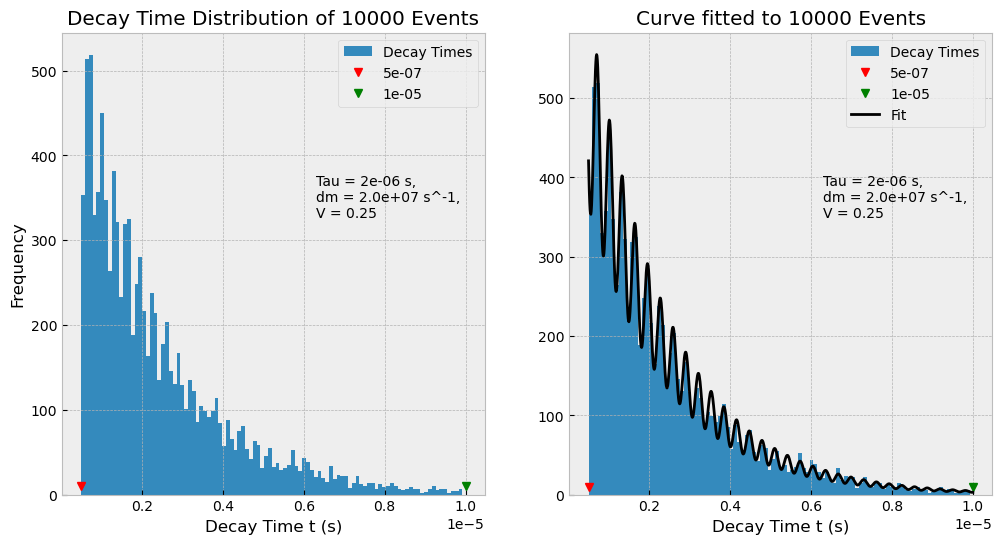

Integral of normalised pdf over bounds: 0.9999822402104821


In [57]:

# use iminuit to fit 
NLL = UnbinnedNLL(data, norm_pdf) # the NLL
m = Minuit(NLL, tau=tau_nom, dm=dm_nom, V=V_nom) # initial values as nominal values


# minimise
m.migrad() # find min of NLL
m.hesse() # find errors


# create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


# SUBPLOT 1 - data
ax[0].hist(data, bins=100, label="Decay Times") # plot the histogram
ax[0].plot(bounds[0], 10, marker="v", color="r", linestyle="None", label="{0}".format(bounds[0])) # lower band label
ax[0].plot(bounds[1], 10, marker="v", color="g", linestyle="None", label="{0}".format(bounds[1])) # upper band label
ax[0].set_title("Decay Time Distribution of 10000 Events")
ax[0].set_xlabel("Decay Time t (s)")
ax[0].set_ylabel("Frequency")
ax[0].text(0.6, 0.6, "Tau = {0} s, \ndm = {1:.1e} s^-1, \nV = {2}".format(tau_nom, dm_nom, V_nom), transform=ax[0].transAxes)
ax[0].legend()


# SUBPLOT 2 - data and fitted curve
x_plot = np.linspace(bounds[0], bounds[1], 1000) # generate x-values for plotting the function
y_plot = norm_pdf(x_plot, m.values["tau"], m.values["dm"], m.values["V"]) # calculate y-values using the fitted function
n, bins, patches = ax[1].hist(data, bins=100, label="Decay Times") # plot the histogram
bin_width = bins[1] - bins[0]
ax[1].plot(bounds[0], 10, marker="v", color="r", linestyle="None", label="{0}".format(bounds[0])) # lower band label
ax[1].plot(bounds[1], 10, marker="v", color="g", linestyle="None", label="{0}".format(bounds[1])) # upper band label
ax[1].plot(x_plot, y_plot * len(data) * bin_width, label="Fit", color="black") # plot the fitted function
ax[1].set_title("Curve fitted to 10000 Events")
ax[1].set_xlabel("Decay Time t (s)")
ax[1].text(0.6, 0.6, "Tau = {0} s, \ndm = {1:.1e} s^-1, \nV = {2}".format(tau_nom, dm_nom, V_nom), transform=ax[1].transAxes)
ax[1].legend()

plt.show()


# check normalisation of pdf
print("Integral of normalised pdf over bounds: {0}".format(integrate.quad(norm_pdf, bounds[0], bounds[1], args=(tau_nom, dm_nom, V_nom))[0]))


- Do this for multiple pseudoexperiments and calculate the mean and standard deviation of the distribution of fitted parameters

In [58]:

# for loop over number of pseudoexperiments
pseudo = 1000
tau_values, dm_values, V_values = np.zeros(pseudo), np.zeros(pseudo), np.zeros(pseudo)  # lists to contain obtained parameter values from each pseudoexperiment


for i in range(pseudo):

    # generate events
    data = generate()


    # fit the data
    NLL = UnbinnedNLL(data, norm_pdf) 
    m = Minuit(NLL, tau=tau_nom, dm=dm_nom, V=V_nom)


    # minimise
    m.migrad()
    m.hesse()


    # collect fitted parameter values
    tau_values[i] = m.values["tau"]
    dm_values[i] = m.values["dm"]
    V_values[i] = m.values["V"]


tau_mean, dm_mean, V_mean = np.average(tau_values), np.average(dm_values), np.average(V_values) # mean
tau_std, dm_std, V_std = np.std(tau_values), np.std(dm_values), np.std(V_values) # standard deviation


- Plot parameter value distributions over the pseudoexperiments

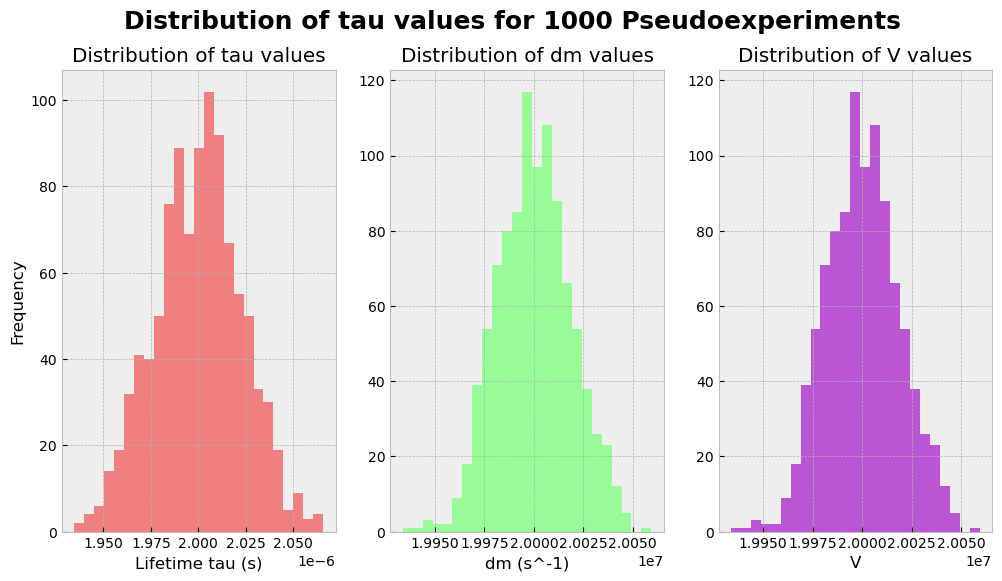

Pseudoexperiments: 1000

fitted tau: 2.000131195564945e-06 +/- 2.2780599344038325e-08 
fitted dm: 20000311.58419264 +/- 18630.792615978084 
fitted V: 0.24920851318612824 +/- 0.01357455062351425


In [60]:

# create a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle("Distribution of tau values for {} Pseudoexperiments".format(pseudo), fontsize=18, fontweight="bold")


# SUBPLOT 1 - tau
ax[0].hist(tau_values, bins=25, color="lightcoral") # plot the histogram
ax[0].set_title("Distribution of tau values".format(pseudo))
ax[0].set_xlabel("Lifetime tau (s)")
ax[0].set_ylabel("Frequency")


# SUBPLOT 2 - dm
ax[1].hist(dm_values, bins=25, color="palegreen") 
ax[1].set_title("Distribution of dm values".format(pseudo))
ax[1].set_xlabel("dm (s^-1)")


# SUBPLOT 2 - V
ax[2].hist(dm_values, bins=25, color="mediumorchid")
ax[2].set_title("Distribution of V values".format(pseudo))
ax[2].set_xlabel("V")

plt.show()


print("Pseudoexperiments: {0}".format(pseudo))
print("\nfitted tau: {0} +/- {1} \nfitted dm: {2} +/- {3} \nfitted V: {4} +/- {5}".format(tau_mean, tau_std, dm_mean, dm_std, V_mean, V_std))


(Precision is standard deviation)

## Step 2: Effect of a background

- the pdf for the background is: $$p(t;\sigma) \propto e^{-\frac{t^2}{2\sigma^2}}$$
$$\sigma = 0.5\times 10^{-6}\ \text{s}$$
- combine data pdf and background pdf with a mixer function for proportions: 1%, 10% and 20% background

In [7]:

# given sigma value
sigma_nom = 0.5e-6


# define signal and background pdfs (neither normalised)
def signal_pdf(t, tau, dm, V):
    return (1 + V*np.sin(dm*t))*np.exp(-t/tau)

def background_pdf(t, sigma):
    return np.exp((-t**2)/2*(sigma**2))


# normalisation constants for signal and background pdfs
N_signal = integrate.quad(signal_pdf, bounds[0], bounds[1], args=(tau_nom, dm_nom, V_nom))[0] # index 0 so as not to include the error
N_background = integrate.quad(background_pdf, bounds[0], bounds[1], args=(sigma_nom))[0]


# define normalised signal and background pdfs
def norm_signal_pdf(t, tau, dm, V):
    return signal_pdf(t, tau, dm, V) / N_signal

def norm_background_pdf(t, sigma):
    return background_pdf(t, sigma) / N_background


In [8]:

# put all this in a function with argument f for background proportion
def generate_samples(f):
    # define mixer function
    def mix(t, sigma, tau, dm, V):
        return f*norm_background_pdf(t, sigma) + (1-f)*norm_signal_pdf(t, tau, dm, V)


    # define cdf
    def cdf(x, sigma, tau, dm, V):
        return integrate.quad(mix, bounds[0], x, args=(sigma, tau, dm, V))[0] # integrate from lower bound to given x


    # interpolation points
    x = np.linspace(bounds[0], bounds[1], 1000)


    # cdf values
    cdf_values = np.array([cdf(i, sigma_nom, tau_nom, dm_nom, V_nom) for i in x])


    # random r's
    r = np.random.rand(10000)


    # inverse transform sampling
    interpolator = interp1d(cdf_values, x)
    samples = interpolator(r) # our generated decay times
    
    return samples # call function with argument f and return the array of generated samples


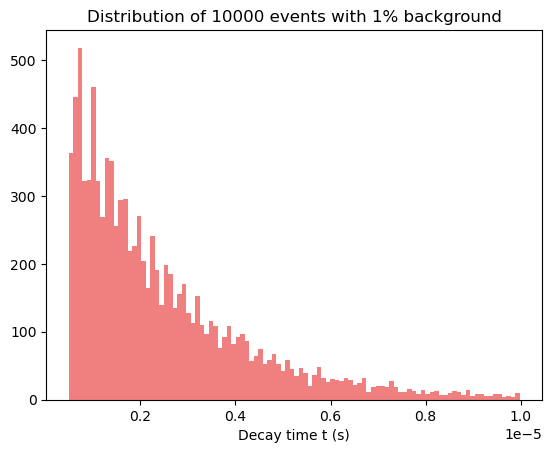

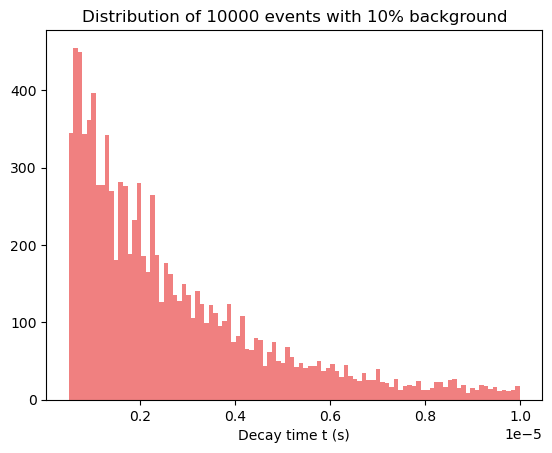

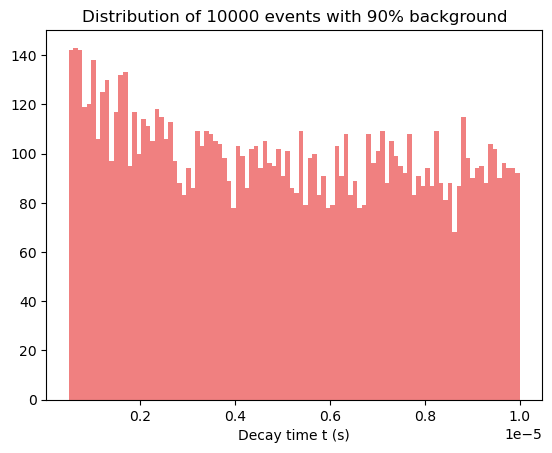

In [9]:
# plot the histogram for 1%, 10% and 20% background
plt.hist(generate_samples(0.01), bins=100, color="lightcoral")
plt.title("Distribution of 10000 events with 1% background")
plt.xlabel("Decay time t (s)")
plt.show()


plt.hist(generate_samples(0.1), bins=100, color="lightcoral")
plt.title("Distribution of 10000 events with 10% background")
plt.xlabel("Decay time t (s)")
plt.show()


plt.hist(generate_samples(0.9), bins=100, color="lightcoral")
plt.title("Distribution of 10000 events with 90% background")
plt.xlabel("Decay time t (s)")
plt.show()

- Fit pseudoexperiments